# This is solution for the Problem2 of the below paper(link is given below)
"A spectral element method for solving the Pennes bioheat transfer equation by using triangular and quadrilateral elements"
https://www.sciencedirect.com/science/article/pii/S0307904X12000339#s0050

In the paper they have used SPECTRAL ELEMENGT METHOD for solving the problem but I have done using the recent application of Machine Learning - PINN(Physics infromed Neuaral Network).
The results have been compared in the different plots. I have created some extra plots for analyisng the temperature distribution in the tissue

In [1]:
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
pip install pyDOE

Note: you may need to restart the kernel to use updated packages.


# All constants
Assumption : tissue as a single layer(l1) of same depth

In [3]:
# time for the simulation

sim_time = 100 # seconds

#shape of the tissue

length = 0.08 # m
depth = 0.03 # m

#for layer 
u_a = 37 # initial temp (deg C)
l1 = 0.017 # thickness of the layer(m)
rho1 = 1000 # density of the layer (kg/m^3)
rhob = 1000 # density of the blood vessel (kg/m^3)
C1 = 4000 # specific heat (J/kg. deg Celsius)
Cb1 = 4000 # specific heat of the blood (J/kg. deg Celsius)
K1 = 0.5 # thermal conductivity of the tissue (W/m. deg Celsius)
Wb1 = 0.0005 # Blood perfusion rate (m^3/s/m^3)
Wb_t = 0.002 # # Blood perfusion rate in tumour region (m^3/s/m^3)
Qm = 420 # metabolic heat in the tissue(W/m3)
Qm_t = 4200 # metabolic heat in the tumour region(W/m3)






In [4]:
import time
import torch
import numpy as np
import scipy.io
from pyDOE import lhs
from physicsinformed import PhysicsInformedContinuous
from scipy.interpolate import griddata
import utilities

# Select gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(450)
np.random.seed(450) 

# Define no. of training points
N0 = 500 # intial values at t = 0 (0,x,z)
N_b = 300
N_f = 20000

# Define feed-forward network architecture
layers = [3, 20, 20, 20, 20, 1]

# Define no. of epochs for each optimizer
epochs_Adam = 8000
epochs_LBFGS = 1000

# Domain bounds for non tumor region
lb = np.array([0,-0.04,0])  # minimum(t,x(width),z(depth))
ub = np.array([sim_time,0.04,0.03]) # maximum(t,x(width),z(depth))

# domian bounds for tumor region
lb_t = np.array([0,-0.01,0.005,])
ub_t = np.array([sim_time,0.01,0.015,])

#lic  = [l1,(l1+l2),(l1+l2+l3)] #layer_interface_coordinates


# Create collocation points with latin hypercube sampling
# for the non tumor region
txz_f = lb + (ub - lb) * lhs(3, N_f) # Creates 20000 sample points in t,x(width),z(depth)
pd1 = pd.DataFrame(txz_f)
i = pd1[(pd1[2]<=0.015) & (pd1[2]>=0.005)].index
j = pd1[(abs(pd1[1])<= 0.01)].index
def common_indices(a, b):   
    a_set = set(a)
    b_set = set(b)
     
    # check length
    if len(a_set.intersection(b_set)) > 0:
        return(a_set.intersection(b_set)) 
    else:
        return("no common elements")
pd1.drop(common_indices(i, j),inplace = True)
txz_f = np.array(pd1)

# for the tumor region
txz_f_t = lb_t + (ub_t - lb_t) * lhs(3, N_f//4) # Creates N_f//3(5000) sample points in t,x(width),z(depth)

# Transform grid into vectors that can be processed by the neural net
'''X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) #Stack arrays in sequence horizontally (column wise)
u_star = u_sol.flatten()[:, None]
flux_star = flux_sol.flatten()[:, None]
'''

# Select random data points for the initial condition
id_rand = np.random.choice(txz_f.shape[0], N0, replace=False) # Choose random 100 indices from 256 total indices of space
x0 = txz_f[:,1:2][id_rand, :] # location of these 100 random points
id_rand1 = np.random.choice(txz_f.shape[0], N0, replace=False)
z0 = txz_f[:,2:3][id_rand1, :]
xz0 = np.concatenate((0 * x0, x0, z0), 1) # (0,x0,z0) initial condition

# Select random data points for the boundary condition

# for top

id_tb = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random 50 indices from 201 total indices of time
tb = txz_f[:,0:1][id_tb, :] # time stamps of those 50 indices
id_xb = np.random.choice(txz_f.shape[0], N_b, replace=False)
xb = txz_f[:,1:2][id_xb, :]

tx0b = np.concatenate((tb, xb, 0*tb+0.03), 1)  

## input data for the bottom (@ z = depth)

id_t_int = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random N_b indices from 20000 total indices 
t_int_ = txz_f[:,0:1][id_t_int, :] # time stamps of those N_b indices
id_x_int = np.random.choice(txz_f.shape[0], N_b, replace=False)
x_int_ = txz_f[:,1:2][id_x_int, :]

txz_bott = np.concatenate((t_int_, x_int_, 0 * t_int_), 1)

    
# for the lateral surfaces (boundary conditions)

#coordinates for lateral surfaces

id_t_surface1 = np.random.choice(txz_f.shape[0], N_b, replace=False)
t_xz_ = txz_f[:,0:1][id_t_surface1, :]
id_x_surface2 = np.random.choice(txz_f.shape[0], N_b, replace=False) 
x_xz_ = txz_f[:,1:2][id_x_surface2, :]
id_z_surface3 = np.random.choice(txz_f.shape[0], N_b, replace=False)
z_xz_ = txz_f[:,2:3][id_z_surface3, :]

xz_lb = np.concatenate((t_xz_, x_xz_ , z_xz_ ), 1) # (t,x,z)  


## input data for the left and right boundaries 

id_t_l = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random N_b indices from 20000 total indices 
t_int_l = txz_f[:,0:1][id_t_l, :] # time stamps of those N_b indices
id_z_l = np.random.choice(txz_f.shape[0], N_b, replace=False)
z_int_l = txz_f[:,1:2][id_z_l, :]

txz_left = np.concatenate((t_int_, z_int_l*0-0.04, z_int_l), 1)

id_t_r = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random N_b indices from 20000 total indices 
t_int_r = txz_f[:,0:1][id_t_r, :] # time stamps of those N_b indices
id_z_r = np.random.choice(txz_f.shape[0], N_b, replace=False)
z_int_r = txz_f[:,1:2][id_z_r, :]
txz_right = np.concatenate((t_int_r, z_int_r*0+0.04, z_int_r), 1)

### TRAINING ###
# Create torch.tensors of training data

#for the initial condition at t=0 # we will have to consider all 3 layers if assumption is removed

t_0 = torch.tensor(xz0[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_0 = torch.tensor(xz0[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_0 = torch.tensor(xz0[:, 2:3], dtype=dtype, requires_grad=True, device=device)

#for the top and bottom boundary condition

t_top = torch.tensor(tx0b[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_top = torch.tensor(tx0b[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_top = torch.tensor(tx0b[:, 2:3], dtype=dtype, requires_grad=True, device=device)

t_bott = torch.tensor(txz_bott[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_bott = torch.tensor(txz_bott[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_bott = torch.tensor(txz_bott[:, 2:3], dtype=dtype, requires_grad=True, device=device)


#for the left and right boundary condition
t_left = torch.tensor(txz_left[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_left = torch.tensor(txz_left[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_left = torch.tensor(txz_left[:, 2:3], dtype=dtype, requires_grad=True, device=device)

t_right = torch.tensor(txz_right[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_right = torch.tensor(txz_right[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_right = torch.tensor(txz_right[:, 2:3], dtype=dtype, requires_grad=True, device=device)


# for the functional error
t_f = torch.tensor(txz_f[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_f = torch.tensor(txz_f[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_f = torch.tensor(txz_f[:, 2:3], dtype=dtype, requires_grad=True, device=device)

# for the functional error
t_f_t = torch.tensor(txz_f_t[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_f_t = torch.tensor(txz_f_t[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_f_t = torch.tensor(txz_f_t[:, 2:3], dtype=dtype, requires_grad=True, device=device)


# Initialize PINN model
PINNModel = PhysicsInformedContinuous(layers,t_0,x_0,z_0,t_top,x_top,z_top,t_bott,x_bott,z_bott,
                                      t_left,x_left,z_left,t_right,x_right,z_right,t_f,x_f,z_f,
                                      t_f_t,x_f_t,z_f_t,u_a,Qm,Qm_t)

# Train the model
start_time = time.time()
PINNModel.train(10000, optimizer='Adam', lr=0.01)
#PINNModel.train(epochs_LBFGS, optimizer='L-BFGS')
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


# Plot training history and predicitons
PINNModel.plot_training_history()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)
model parameters on gpu: False
Epoch (Adam): 0, Cost: 96.67178344726562, Bound_loss: 1.3657716512680054, Fun_loss: 95.3044662475586, Ini_loss: 0.0015447329496964812
Epoch (Adam): 100, Cost: 23.352680206298828, Bound_loss: 1.1894093751907349, Fun_loss: 21.784805297851562, Ini_loss: 0.3784646689891815
Epoch (Adam): 200, Cost: 23.051246643066406, Bound_loss: 1.2202256917953491, Fun_loss: 21.4638671875, Ini_loss: 0.3671532869338989
Epoch (Adam): 300, Cost: 24.347929000854492, Bound_loss: 1.2402819395065308, Fun_loss: 22.334753036499023, Ini_loss: 0.7728936672210693
Epoch (Adam): 400, Cost: 22.54999542236328, Bound_loss: 1.2615076303482056

KeyboardInterrupt: 

In [5]:
PINNModel.train(10000, optimizer='Adam', lr=0.001)

Epoch (Adam): 0, Cost: 6.078404426574707, Bound_loss: 1.9323288202285767, Fun_loss: 3.7288436889648438, Ini_loss: 0.4172322154045105
Epoch (Adam): 100, Cost: 4.8440961837768555, Bound_loss: 1.8963878154754639, Fun_loss: 2.5377347469329834, Ini_loss: 0.40997374057769775
Epoch (Adam): 200, Cost: 4.5927958488464355, Bound_loss: 1.853809118270874, Fun_loss: 2.3594958782196045, Ini_loss: 0.3794909119606018
Epoch (Adam): 300, Cost: 4.317052841186523, Bound_loss: 1.832078218460083, Fun_loss: 2.1324877738952637, Ini_loss: 0.3524870276451111
Epoch (Adam): 400, Cost: 4.057013034820557, Bound_loss: 1.7141062021255493, Fun_loss: 2.006178140640259, Ini_loss: 0.33672869205474854
Epoch (Adam): 500, Cost: 3.7061920166015625, Bound_loss: 1.689928412437439, Fun_loss: 1.7001198530197144, Ini_loss: 0.31614384055137634
Epoch (Adam): 600, Cost: 3.451288938522339, Bound_loss: 1.649569034576416, Fun_loss: 1.5217499732971191, Ini_loss: 0.2799699902534485
Epoch (Adam): 700, Cost: 3.164501905441284, Bound_loss: 

KeyboardInterrupt: 

In [6]:
PINNModel.train(10000, optimizer='Adam', lr=0.0001)

Epoch (Adam): 0, Cost: 1.7963565587997437, Bound_loss: 1.314764142036438, Fun_loss: 0.46745195984840393, Ini_loss: 0.014140522107481956
Epoch (Adam): 100, Cost: 1.7865819931030273, Bound_loss: 1.3155032396316528, Fun_loss: 0.4584033489227295, Ini_loss: 0.012675413861870766
Epoch (Adam): 200, Cost: 1.7848191261291504, Bound_loss: 1.3155115842819214, Fun_loss: 0.45680972933769226, Ini_loss: 0.012497798539698124
Epoch (Adam): 300, Cost: 1.7827973365783691, Bound_loss: 1.3155033588409424, Fun_loss: 0.45484358072280884, Ini_loss: 0.012450414709746838
Epoch (Adam): 400, Cost: 1.78048837184906, Bound_loss: 1.3154082298278809, Fun_loss: 0.4526413381099701, Ini_loss: 0.01243874616920948
Epoch (Adam): 500, Cost: 1.777928352355957, Bound_loss: 1.3152728080749512, Fun_loss: 0.45022284984588623, Ini_loss: 0.012432705610990524
Epoch (Adam): 600, Cost: 1.7751507759094238, Bound_loss: 1.3151181936264038, Fun_loss: 0.44760486483573914, Ini_loss: 0.01242762990295887
Epoch (Adam): 700, Cost: 1.7721849679

Epoch (Adam): 6000, Cost: 1.6307251453399658, Bound_loss: 1.302777886390686, Fun_loss: 0.3157288432121277, Ini_loss: 0.012218421325087547
Epoch (Adam): 6100, Cost: 1.6271779537200928, Bound_loss: 1.3024832010269165, Fun_loss: 0.31251412630081177, Ini_loss: 0.012180558405816555
Epoch (Adam): 6200, Cost: 1.6252774000167847, Bound_loss: 1.302213191986084, Fun_loss: 0.3108886778354645, Ini_loss: 0.012175528332591057
Epoch (Adam): 6300, Cost: 1.6235648393630981, Bound_loss: 1.302133321762085, Fun_loss: 0.3092203438282013, Ini_loss: 0.012211211957037449
Epoch (Adam): 6400, Cost: 1.6215457916259766, Bound_loss: 1.3016395568847656, Fun_loss: 0.30771559476852417, Ini_loss: 0.012190544977784157
Epoch (Adam): 6500, Cost: 1.6196372509002686, Bound_loss: 1.3013393878936768, Fun_loss: 0.3061020076274872, Ini_loss: 0.012195839546620846
Epoch (Adam): 6600, Cost: 1.6178059577941895, Bound_loss: 1.3010163307189941, Fun_loss: 0.3045728802680969, Ini_loss: 0.012216661125421524
Epoch (Adam): 6700, Cost: 1.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


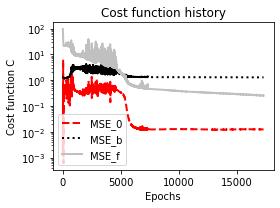

In [7]:
PINNModel.plot_training_history()

In [8]:
PINNModel.train(10000, optimizer='Adam', lr=0.0001)

Epoch (Adam): 0, Cost: 1.5532305240631104, Bound_loss: 1.2874019145965576, Fun_loss: 0.25338342785835266, Ini_loss: 0.012445221655070782
Epoch (Adam): 100, Cost: 1.5529409646987915, Bound_loss: 1.2871220111846924, Fun_loss: 0.25328555703163147, Ini_loss: 0.01253337413072586
Epoch (Adam): 200, Cost: 1.5524754524230957, Bound_loss: 1.2870291471481323, Fun_loss: 0.252969354391098, Ini_loss: 0.012476869858801365
Epoch (Adam): 300, Cost: 1.5519275665283203, Bound_loss: 1.2868655920028687, Fun_loss: 0.2526245713233948, Ini_loss: 0.012437309138476849
Epoch (Adam): 400, Cost: 1.551281213760376, Bound_loss: 1.286664605140686, Fun_loss: 0.2522082030773163, Ini_loss: 0.012408328242599964
Epoch (Adam): 500, Cost: 1.5505471229553223, Bound_loss: 1.2864333391189575, Fun_loss: 0.251730352640152, Ini_loss: 0.012383412569761276
Epoch (Adam): 600, Cost: 1.5497326850891113, Bound_loss: 1.2861756086349487, Fun_loss: 0.2511973977088928, Ini_loss: 0.012359697371721268
Epoch (Adam): 700, Cost: 1.548842310905

Epoch (Adam): 6000, Cost: 1.4796452522277832, Bound_loss: 1.2530421018600464, Fun_loss: 0.21289977431297302, Ini_loss: 0.013703372329473495
Epoch (Adam): 6100, Cost: 1.478887677192688, Bound_loss: 1.2524094581604004, Fun_loss: 0.21268698573112488, Ini_loss: 0.013791238889098167
Epoch (Adam): 6200, Cost: 1.4773072004318237, Bound_loss: 1.2514232397079468, Fun_loss: 0.21201710402965546, Ini_loss: 0.013866866938769817
Epoch (Adam): 6300, Cost: 1.4761433601379395, Bound_loss: 1.250618577003479, Fun_loss: 0.21158939599990845, Ini_loss: 0.013935346156358719
Epoch (Adam): 6400, Cost: 1.4749748706817627, Bound_loss: 1.2497683763504028, Fun_loss: 0.2111707180738449, Ini_loss: 0.014035867527127266
Epoch (Adam): 6500, Cost: 1.4738051891326904, Bound_loss: 1.2489162683486938, Fun_loss: 0.21076634526252747, Ini_loss: 0.014122609049081802
Epoch (Adam): 6600, Cost: 1.4729173183441162, Bound_loss: 1.2480988502502441, Fun_loss: 0.21059904992580414, Ini_loss: 0.014219347387552261
Epoch (Adam): 6700, Cos

## Comparison of the results for Temperature distribution vs time
By using theh analytical solution provided in the paper, I have compared the results of the PINN.
Both the lines are almost overlapping

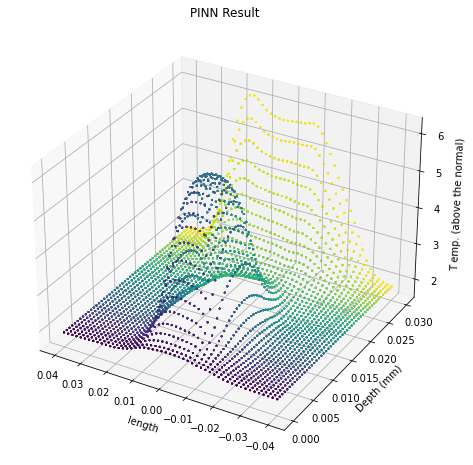

In [59]:
n = 50
l = 50
x_ = (np.array([np.linspace(-0.04,0.04,n)]).T)
z_ = (np.array([np.linspace(0,0.03,n)]).T)
t_ = (np.array([np.linspace(0,100,n)]).T)
T_,X,Z = np.meshgrid(t_,x_,z_)
X_star = np.hstack((T_.flatten()[:, None], X.flatten()[:, None],Z.flatten()[:, None]))

x_star = torch.tensor(X_star[:,1:2], dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(X_star[:,2:3], dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(X_star[:,0:1], dtype=dtype, requires_grad=True, device=device)


Tt = PINNModel.u_nn(t_star*0+100, x_star,z_star).detach().cpu().numpy()
x = x_star.detach().cpu().numpy().T[0]
z = z_star.detach().cpu().numpy().T[0]
t = t_star.detach().cpu().numpy().T[0]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim3d(37,37.5)
ax.invert_xaxis()
ax.scatter(x,z, Tt,
           linewidths=1, alpha=.1,   
           s = 1,
           c=z)
ax.set_ylabel('Depth (mm)')
ax.set_zlabel('T emp. (above the normal)')
ax.set_xlabel('length')
plt.title('PINN Result')
plt.show()

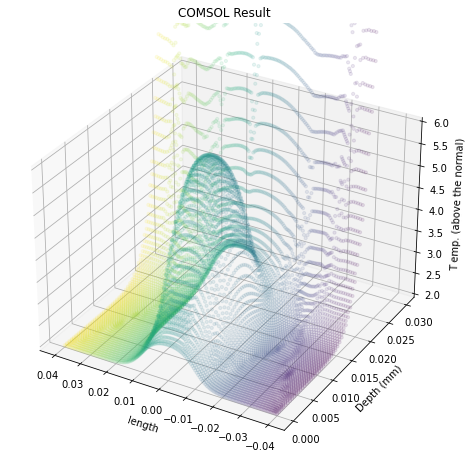

In [60]:
datan= pd.read_csv('data.csv')
T1 = np.array(datan.iloc[:,2:3])
x1 = np.array(datan.iloc[:,0:1]).T[0]
z1 = np.array(datan.iloc[:,1:2]).T[0]
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim3d(37,37.5)
ax.invert_xaxis()
ax.scatter(z1,x1, T1,
           linewidths=1, alpha=.1,   
           s = 10,
           c=z1)
ax.set_zlim3d(2,6)
ax.set_ylabel('Depth (mm)')
ax.set_zlabel('T emp. (above the normal)')
ax.set_xlabel('length')
plt.title('COMSOL Result')


plt.show()


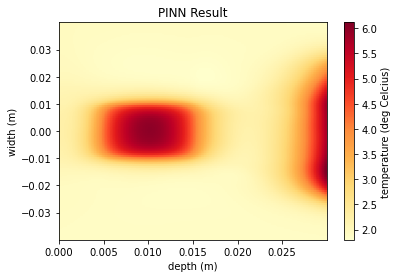

In [61]:
n = 100
l = 100
x_ = (np.array([np.linspace(-0.04,0.04,n)]).T)
z_ = (np.array([np.linspace(0,0.03,n)]).T)
t_ = (np.array([np.linspace(0,100,n)]).T)
T_,X,Z = np.meshgrid(t_,x_,z_)
X_star = np.hstack((T_.flatten()[:, None], X.flatten()[:, None],Z.flatten()[:, None]))

x_star = torch.tensor(X_star[:,1:2], dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(X_star[:,2:3], dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(X_star[:,0:1], dtype=dtype, requires_grad=True, device=device)


Tt = PINNModel.u_nn(t_star*0+100, x_star,z_star).detach().cpu().numpy()
x = x_star.detach().cpu().numpy().T[0]
z = z_star.detach().cpu().numpy().T[0]
t = t_star.detach().cpu().numpy().T[0]


plt.figure()
plt.imshow(Tt.reshape(10000,100),cmap='YlOrRd',extent=[min(z),max(z),min(x),max(x)],aspect='auto')
plt.ylabel('width (m)')
plt.xlabel('depth (m)')
plt.title('Time = 100 s')
plt.colorbar(label='temperature (deg Celcius)')
plt.title('PINN Result')


plt.show()

In [56]:
T1

array([[1.9621299 ],
       [1.96212729],
       [1.96212575],
       ...,
       [3.80401904],
       [3.6125601 ],
       [3.76448625]])

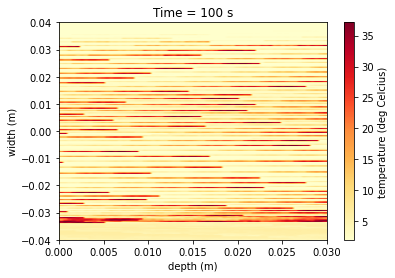

In [58]:

plt.figure()
plt.imshow(T1.reshape(181,64),cmap='YlOrRd',extent=[min(x1),max(x1),min(z1),max(z1)],aspect='auto')
plt.ylabel('width (m)')
plt.xlabel('depth (m)')
plt.title('Time = 100 s')
plt.colorbar(label='temperature (deg Celcius)')
plt.show()

In [ ]:
Tt.shape

In [ ]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda


In [ ]:
cyclical_lr(1, min_lr=3e-4, max_lr=3e-3)

In [30]:
def print_factors(x):
   print("The factors of",x,"are:")
   for i in range(1, x + 1):
       if x % i == 0:
           print(i)

num = 181

print_factors(num)

The factors of 181 are:
1
181


In [ ]:
175*245